In [52]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

DEFAULT_RESOLUTION=30

In [2]:
# Definition of a Curve
class Curve:
    # Constructor
    def __init__(self, list_of_points, closed=False):
        self.list_of_points = list_of_points
        self.closed = closed
        self.J = len(list_of_points)
    
    # Square Bracket Overload
    def __getitem__(self, key):
        return self.list_of_points[key % self.J]
    def __setitem__(self, key, value):
        self.list_of_points[key] = value
    
    # Length
    def __len__(self):
        return self.J
    
    # Curve Addition
    def __add__(self, otherCurve):
        if len(self) == len(otherCurve) and self.closed == otherCurve.closed:
            return Curve([self[i] + otherCurve[i] for i in range(len(self))])
    
    # Curve Length
    def curveLength(self):
        l = 0
        for i in range(self.J - 1):
            edgeLength = np.linalg.norm(self[i + 1] - self[i])
            l += edgeLength ** 2
        if self.closed:
            edgeLength = np.linalg.norm(self[-1] - self[0])
            l += edgeLength ** 2
        return l

In [3]:
# Simple Curve Energy Version 2 (Averaged over 4 points)
def simpleCurveEnergy2(curve, alpha=1):
    J = curve.J

    integral = 0
    for i in range(J):
        for j in range(J):
            # Undefined for |i - j| <= 1
            if abs(i - j) <= 1 or abs(i - j + J) <= 1 or abs(i - j - J) <= 1:
                continue

            contribution = 1 / np.linalg.norm(curve[i] - curve[j]) ** alpha + 1 / np.linalg.norm(curve[i] - curve[j+1]) ** alpha
            contribution += 1 / np.linalg.norm(curve[i+1] - curve[j]) ** alpha + 1 / np.linalg.norm(curve[i+1] - curve[j+1]) ** alpha
            contribution /= 4
            integral += contribution * np.linalg.norm(curve[i] - curve[i+1]) * np.linalg.norm(curve[j] - curve[j+1])
    
    return integral


In [53]:
def curveFromFourierCoefficients(xa, xb, ya, yb, za, zb, resolution=DEFAULT_RESOLUTION):
    J = len(xa) - 1

    def fourierFromCoefficient(an, bn):
        return lambda x : an[0]/2 + sum([np.cos(x)*an[i] + np.sin(x)*bn[i] for i in range(1, J + 1)])
    
    fx = fourierFromCoefficient(xa, xb)
    fy = fourierFromCoefficient(ya, yb)
    fz = fourierFromCoefficient(za, zb)

    points = []
    for i in range(resolution):
        theta = 2 * np.pi * i / resolution
        points.append(np.array([
            fx(theta),
            fy(theta),
            fz(theta)
        ]))
    
    return Curve(points, True)

In [55]:
def curveFourierDifferential(xa, xb, ya, yb, za, zb, perturbation=0.001, resolution=DEFAULT_RESOLUTION, alpha=0.5):
    J = len(xa) - 1

    variables = np.concatenate([xa, xb, ya, yb, za, zb])
    differential = np.zeros(len(variables), dtype="float64")
    for i in range(len(variables)):
        temp = variables[i]
        variables[i] += perturbation
        xac, xbc, yac, ybc, zac, zbc = np.split(variables, 6)
        tempCurve = curveFromFourierCoefficients(xac, xbc, yac, ybc, zac, zbc, resolution=resolution)
        energyP = simpleCurveEnergy2(tempCurve, alpha=alpha)
        variables[i] = temp
        variables[i] -= perturbation
        xac, xbc, yac, ybc, zac, zbc = np.split(variables, 6)
        tempCurve = curveFromFourierCoefficients(xac, xbc, yac, ybc, zac, zbc, resolution=resolution)
        energyN = simpleCurveEnergy2(tempCurve, alpha=alpha)
        differential[i] = (energyP - energyN) / (2 * perturbation)
    
    return differential

In [44]:
def curvePlot(curve):
    J = curve.J

    xpoints = []
    ypoints = []
    zpoints = []
    for i in range(J):
        xpoints.append(curve[i][0])
        ypoints.append(curve[i][1])
        zpoints.append(curve[i][2])
    
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.plot(xpoints, ypoints, zpoints)
    ax.set_xlim((-2,2))
    ax.set_ylim((-2,2))
    ax.set_zlim((-2,2))
    plt.show()

In [60]:
def fourierCurveSDM(xa, xb, ya, yb, za, zb, resolution=DEFAULT_RESOLUTION, alpha=0.5, M=100, stepsize=0.01, qPlot=False):
    x = np.concatenate([xa, xb, ya, yb, za, zb])
    for t in range(M):
        xac, xbc, yac, ybc, zac, zbc = np.split(x, 6)
        x = x - stepsize * curveFourierDifferential(xac, xbc, yac, ybc, zac, zbc, perturbation=0.001, resolution=resolution, alpha=alpha)

        if qPlot:
            tempcurve = curveFromFourierCoefficients(xac, xbc, yac, ybc, zac, zbc, resolution=resolution)
            curvePlot(tempcurve)
    

74.22396119440131


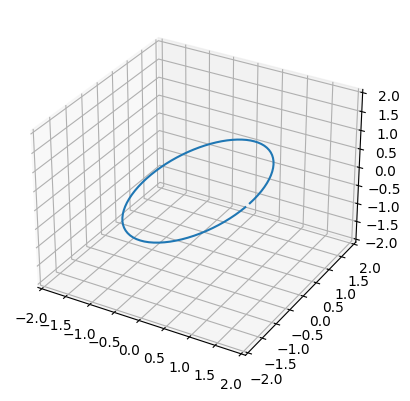

In [61]:
xa = np.array([0, 1, 0, 0], dtype="float64")
xb = np.array([0, 0, 0, 0], dtype="float64")
ya = np.array([0, 0, 0, 0], dtype="float64")
yb = np.array([0, 2, 0, 0], dtype="float64")
za = np.array([0, 0, 0, 0], dtype="float64")
zb = np.array([0, 0, 0, 0], dtype="float64")

curve = curveFromFourierCoefficients(xa, xb, ya, yb, za, zb, resolution=80)
print(simpleCurveEnergy2(curve, alpha=0.5))
curvePlot(curve)

In [59]:
curveFourierDifferential(xa, xb, ya, yb, za, zb, 0.001)

array([ 0.00000000e+00,  2.20440677e+01,  2.20264925e+01,  2.20088988e+01,
        0.00000000e+00, -2.48689958e-11, -1.71401987e-02, -3.42803971e-02,
       -3.55271368e-12,  7.35369820e-03, -9.78655378e-03, -2.69268220e-02,
        0.00000000e+00,  3.67242810e+01,  3.67134607e+01,  3.67026385e+01,
        0.00000000e+00,  0.00000000e+00, -2.20673169e-02, -4.41346202e-02,
        0.00000000e+00, -3.32442518e-05, -1.84067080e-02, -3.67801660e-02])

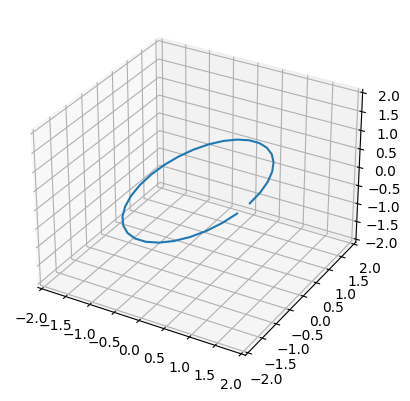

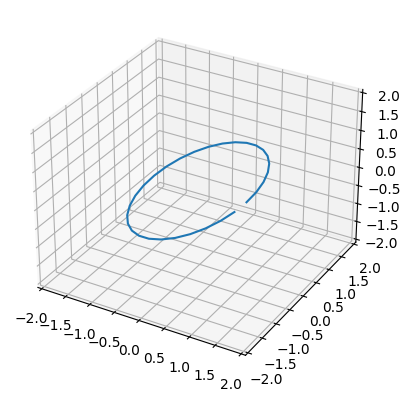

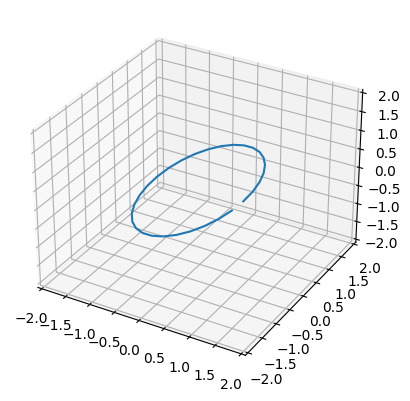

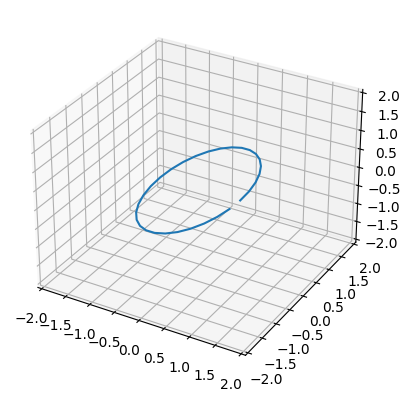

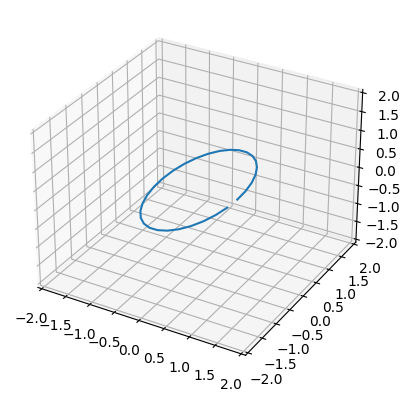

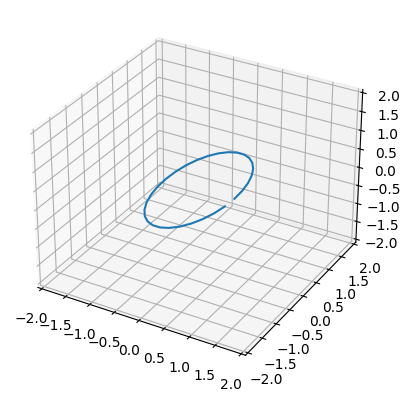

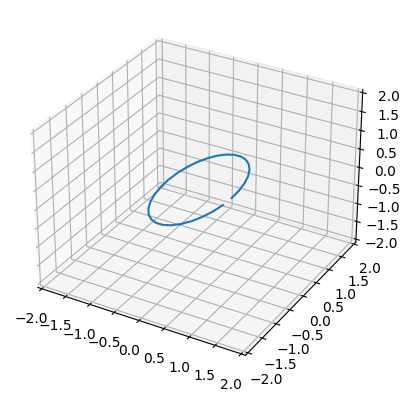

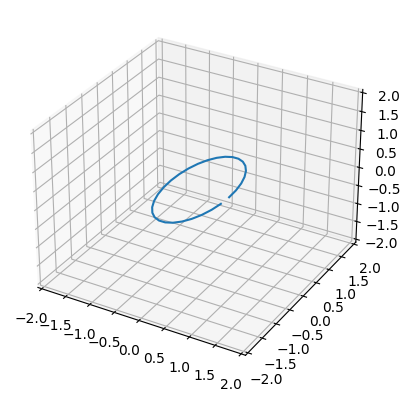

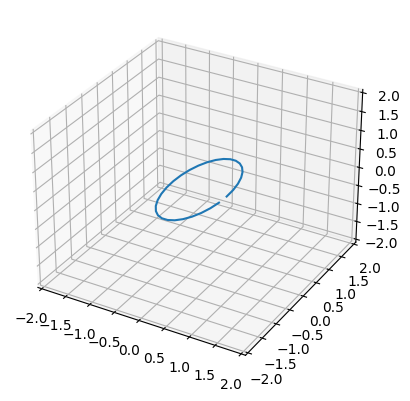

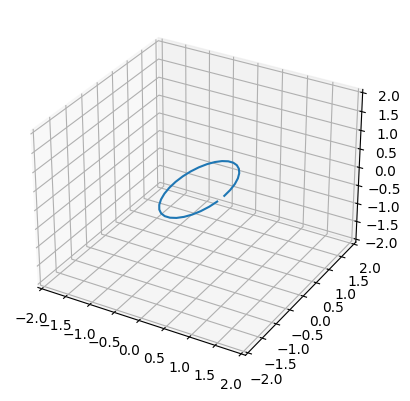

In [63]:
fourierCurveSDM(xa, xb, ya, yb, za, zb, resolution=DEFAULT_RESOLUTION, alpha=0.5, M=1000, stepsize=0.001, qPlot=True)